In [1]:
#!/usr/bin/env python

try:
    import gi

    gi.require_version("NumCosmo", "1.0")
    gi.require_version("NumCosmoMath", "1.0")
except:
    pass

import math
import matplotlib.pyplot as plt
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm
import numpy as np
import sys

sys.path.insert(0, "../../scripts")

import pyccl as ccl


Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import scipy.integrate
import astropy.units as u
import pandas as pd
from astropy.io import fits
from astropy.table import Table

%matplotlib inline

In [2]:
Omega_c = 0.22
Omega_b = 0.0448
cosmo = Nc.HICosmoDEXcdm()
reion = Nc.HIReionCamb.new()
prim = Nc.HIPrimPowerLaw.new()

cosmo.add_submodel(reion)
cosmo.add_submodel(prim)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFunc.new_from_name("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new(tf)

# psml = Nc.PowspecMLCBE.new ()
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()


cosmo.props.H0 = 71
cosmo.props.Omegab = 0.0448
cosmo.props.Omegac = 0.22
cosmo.props.Omegax = 1.0 - (Omega_b + Omega_c)

cosmo.omega_x2omega_k()
cosmo.param_set_by_name("Omegak", 0.0)

prim.props.n_SA = 0.963

old_amplitude = math.exp(prim.props.ln10e10ASA)
prim.props.ln10e10ASA = math.log(
    (0.8 / cosmo.sigma8(psf)) ** 2 * old_amplitude
)


In [3]:
# Init and final redshift. Sky area
zl = 0.0
zu = 1.0
area = 439.78986
# Numcosmo Cluster Abundance

# First we need to define the multiplicity function here we will use the tinker
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_linear_interp(True)
mulf.set_mdef(Nc.MultiplicityFuncMassDef.MEAN)
mulf.set_Delta(200)


# Mass fuction definition
hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.set_area_sd(area)

# Cluster abundance obj, mass obj, redshift obj
ca = Nc.ClusterAbundance.new(hmf, None)
cluster_m = Nc.ClusterMass.new_from_name(
    "NcClusterMassNodist{'lnM-min':<%20.15e>, 'lnM-max':<%20.15e>}"
    % (math.log(10) * np.log10(1e13), math.log(10) * np.log10(1e15))
)
cluster_z = Nc.ClusterRedshift.new_from_name(
    "NcClusterRedshiftNodist{'z-min': <%20.15e>, 'z-max':<%20.15e>}" % (zl, zu)
)

ncount_nodist = Nc.DataClusterNCount.new(
    ca, "NcClusterRedshiftNodist", "NcClusterMassNodist"
)
ca.prepare(cosmo, cluster_z, cluster_m)
mset = Ncm.MSet.new_array([cosmo, cluster_z, cluster_m])

## Generating Clusters

In [6]:
rng = Ncm.RNG.seeded_new(None, 3)
ncount_nodist.init_from_sampling(mset, area * ((np.pi / 180) ** 2), rng)


In [7]:
ncount_nodist.catalog_save ("ncount_nodist.fits", True)
ncount_nodist.catalog_load("ncount_nodist.fits")

ncdata_fits = fits.open("ncount_nodist.fits")
# ncdata_fits.info()

ncdata_data = ncdata_fits[1].data

ncdata_Table = Table(ncdata_data)
ncdata_Table.columns
# ncdata_Table.sort('LNM_TRUE')

display(ncdata_Table)

Z_OBS,LNM_OBS,Z_TRUE,LNM_TRUE
float64,float64,float64,float64
0.34268675929004955,30.438653932249263,0.34268675929004955,30.438653932249263
0.8150501350830148,29.957015795116654,0.8150501350830148,29.957015795116654
0.40705157089198984,30.452990672541485,0.40705157089198984,30.452990672541485
0.6606167338450368,30.734925265394228,0.6606167338450368,30.734925265394228
0.4775429214757287,30.209762259709706,0.4775429214757287,30.209762259709706
0.5903908787594252,30.812417048702898,0.5903908787594252,30.812417048702898
0.6870685372767062,30.617669711049068,0.6870685372767062,30.617669711049068
0.9473757754364667,29.95152676425539,0.9473757754364667,29.95152676425539
0.8582998782971848,30.527461702751353,0.8582998782971848,30.527461702751353


[0.01067516 0.25800542 0.50533569 0.75266596 0.99999622] [13.00000498 13.39915426 13.79830354 14.19745282 14.5966021  14.99575138]
213718.0
[[6.0630e+03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [0.0000e+00 2.4440e+03 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 7.9600e+02 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 2.0800e+02 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.

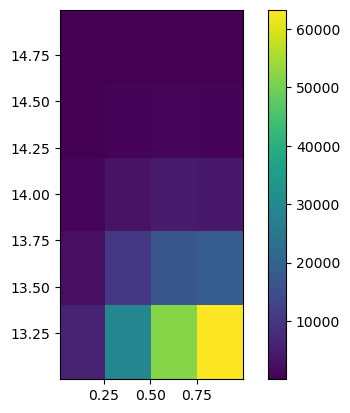

In [8]:
from scipy import stats
data_table = Table(ncdata_data)
cluster_z = data_table["Z_OBS"]
cluster_logM = np.log10(np.exp(data_table["LNM_TRUE"]))

N_m = 5  # number of mass bins
N_z = 4  # number of redshift bins

data_lz, z_edges, m_edges, im = plt.hist2d(cluster_z, (cluster_logM), bins=[N_z, N_m])


print(z_edges, m_edges)
print(np.sum(data_lz))
plt.colorbar()
covariance = np.zeros((N_m * N_z, N_m * N_z))
np.fill_diagonal(covariance, (data_lz.flatten()))


plt.imshow((covariance))
print(covariance)

In [9]:
from firecrown.sacc_support import sacc
import itertools
s_count = sacc.Sacc()
bin_z_labels = []
bin_richness_labels = []

survey_name = "NC_mock_redshift_mass"
s_count.add_tracer("cluster_survey", survey_name, area)

for i, z_bin in enumerate(zip(z_edges[:-1], z_edges[1:])):
    lower, upper = z_bin
    print(z_bin)
    bin_z_label = f"bin_z_{i}"
    s_count.add_tracer("bin_z", bin_z_label, lower, upper)
    bin_z_labels.append(bin_z_label)

for i, richness_bin in enumerate(zip(m_edges[:-1], m_edges[1:])):
    lower, upper = richness_bin
    print(richness_bin)
    bin_richness_label = f"bin_mass_{i}"
    s_count.add_tracer(
        "bin_logM", bin_richness_label, lower, upper
    )
    bin_richness_labels.append(bin_richness_label)

cluster_count = sacc.standard_types.cluster_counts
cluster_mass = sacc.standard_types.cluster_mean_log_mass

counts_and_edges = zip(
    data_lz.flatten(), itertools.product(bin_z_labels, bin_richness_labels)
)

for counts, (bin_z_label, bin_richness_label) in counts_and_edges:
    s_count.add_data_point(
        cluster_count, (survey_name, bin_z_label, bin_richness_label), int(counts)
    )

# Then the add the covariance and save the file
s_count.add_covariance(covariance)
s_count.to_canonical_order()
s_count.save_fits("cluster_redshift_richness_sacc_data.fits", overwrite=True)

(0.01067515859037085, 0.2580054241823518)
(0.2580054241823518, 0.5053356897743327)
(0.5053356897743327, 0.7526659553663136)
(0.7526659553663136, 0.9999962209582945)
(13.00000498291913, 13.399154263229311)
(13.399154263229311, 13.798303543539493)
(13.798303543539493, 14.197452823849677)
(14.197452823849677, 14.596602104159858)
(14.596602104159858, 14.99575138447004)


In [10]:
sacc_data2 = sacc.Sacc.load_fits("./cluster_redshift_richness_sacc_data.fits")
sacc_data2.data

[DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_0', 'bin_mass_0'), value=6063, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_0', 'bin_mass_1'), value=2444, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_0', 'bin_mass_2'), value=796, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_0', 'bin_mass_3'), value=208, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_0', 'bin_mass_4'), value=37, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_1', 'bin_mass_0'), value=29036, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_1', 'bin_mass_1'), value=10359, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_1', 'bin_mass_2'), value=3066, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_1', 'bin_m

## Comparison with firecrown

In [11]:
import firecrown
from firecrown.models.cluster_abundance import ClusterAbundance
from firecrown.models.cluster_mass_true import ClusterMassTrueArgument, ClusterMassTrue
from firecrown.models.cluster_redshift_spec import ClusterRedshiftSpecArgument
import pyccl as ccl
from typing import Any, Dict
cosmo_ccl = ccl.Cosmology(
    Omega_c=Omega_c,
    Omega_b=Omega_b,
    h=0.71,
    sigma8=0.8,
    n_s=0.963,
)
cluster_mass_t = ClusterMassTrue()
hmd_200 = ccl.halos.MassDef200m()
hmf_args: Dict[str, Any] = {}
hmf_name = "Tinker08"
cluster_abundance = ClusterAbundance(hmd_200, hmf_name, hmf_args, sky_area=area)
z_bins = z_edges
r_bins = m_edges
cluster_counts_list = []
for i in range(0,4):
    for j in range(0,5):
        bin_ij = ((z_bins[i], z_bins[i+1]),(r_bins[j], r_bins[j+1]))
        print(bin_ij)
        cluster_mass_bin = ClusterMassTrueArgument(r_bins[j], r_bins[j+1])
        cluster_z_bin = ClusterRedshiftSpecArgument(z_bins[i], z_bins[i+1])
        cluster_counts =cluster_abundance.compute(cosmo_ccl, cluster_mass_bin, cluster_z_bin)
        cluster_counts_list.append(cluster_counts)

print(cluster_counts_list)
print(data_lz)

((0.01067515859037085, 0.2580054241823518), (13.00000498291913, 13.399154263229311))
((0.01067515859037085, 0.2580054241823518), (13.399154263229311, 13.798303543539493))
((0.01067515859037085, 0.2580054241823518), (13.798303543539493, 14.197452823849677))
((0.01067515859037085, 0.2580054241823518), (14.197452823849677, 14.596602104159858))
((0.01067515859037085, 0.2580054241823518), (14.596602104159858, 14.99575138447004))
((0.2580054241823518, 0.5053356897743327), (13.00000498291913, 13.399154263229311))
((0.2580054241823518, 0.5053356897743327), (13.399154263229311, 13.798303543539493))
((0.2580054241823518, 0.5053356897743327), (13.798303543539493, 14.197452823849677))
((0.2580054241823518, 0.5053356897743327), (14.197452823849677, 14.596602104159858))
((0.2580054241823518, 0.5053356897743327), (14.596602104159858, 14.99575138447004))
((0.5053356897743327, 0.7526659553663136), (13.00000498291913, 13.399154263229311))
((0.5053356897743327, 0.7526659553663136), (13.399154263229311, 1